# Game Play
Changes:
- Include user validation to ensure they input proper column and color
- Make sure bot can only play legel moves.
- Record the bot's last move and display at the top.

Future Changes: 
- We'll want to use buttons for selecting color and columns
- Block at least one of the wins even if there is a two-way win?
- Include a stall before the bot's move is played?

What to include in the environment that wasn't included before:
- matplotlib
- seaborn
- Issue with loading model. Had to use to load the model:
    - ```{python}
        custom_objects = {
            'softmax_v2': tf.keras.activations.softmax
        }
        model = load_model('best_connect4_cnn.h5', custom_objects=custom_objects)
      ```

In [4]:
# Check environment being used!!
import sys
print(sys.version) # should be 3.9.19 to match Femke's

# either use virtual environment or use requirements.txt versions by running the line below
# your python version still might not be right though, so using the virtual environment is the safest.
# Also, if you use a package that isn't installed in the virtual environment, then you can take note of it
# and we can add it
# Can also use this to reset packages to the proper versions within requirements.txt in case you changed anything

# !pip install -r requirements.txt

3.9.19 (main, May  6 2024, 14:39:30) 
[Clang 14.0.6 ]


In [5]:
# Load libraries

# Data
import numpy as np
import pandas as pd
import pickle
import random

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output # to clear plot output

# Models
import tensorflow as tf
from tensorflow.keras.models import load_model

# System
import time # stall between moves

## Functions for Play

In [12]:
def update_board(board_temp,color,column):
    """
    Update the game board by placing a checker in the specified column.

    This function takes the current board status, the player's checker color,
    and the column in which they want to place the checker, then updates the board accordingly.
    If the column is full, an error will be returned.

    Args:
        board_temp (numpy.ndarray): A 2x6x7 representation of the game board.
            The first layer corresponds to one player, and the second layer to the other.
            Values are 0 (empty) or 1 (occupied).
        color (str): The color of the checker, either 'red' or 'yellow'.
            'red' corresponds to the first layer (index 0), and 'yellow' to the second layer (index 1).
        column (int): The column (0 through 6) where the checker should be placed.
            If the column is full, the board remains unchanged.

    Returns:
        numpy.ndarray: The updated board after placing the checker.
        If the column is full, an error will be returned.

    Notes:
        - The board is copied before making modifications, ensuring the original input remains unchanged.
        - Maybe we should ask the player for another move if they select something invalid.
    """
    board = board_temp.copy()
    ncol = board.shape[1]
    nrow = board.shape[0]

    while True:
        # Check if selected column is full
        # this seems silly, but actually faster to run than using sum because of overhead!
        colsum = board[0,column,0]+board[1,column,0]+ board[2,column,0] + board[3,column,0] + board[4,column,0] + board[5,column,0] + board[0,column,1] + board[1,column,1] + board[2,column,1] + board[3,column,1] + board[4, column,1] + board[5, column,1]
        if colsum < nrow:
            break # Valid column found, exit loop
        else:
            print(f'Column {column} is full. Please select a different column.')
            column = int(input("Enter a new column (1-7): ")) # 1-7 for human interpretability

    row = int(5-colsum) # Find the next available row: returns index 0 - 5
    if row > -0.5:
      # i.e. as long as we have a slot available
        if color == 'red':
            board[row,column,0] = 1
        else:
            board[row,column,1] = 1
    return board

In [7]:
def check_for_win(board,col):
    """
    Check for a winning condition in the game after a move in the specified column.

    This function evaluates the board to determine if the most recent move in the specified
    column resulted in a win. It checks for four consecutive checkers of the same color
    in vertical, horizontal, and diagonal directions.

    Args:
        board (numpy.ndarray): A 2x6x7 representation of the game board.
            The first layer corresponds to the 'red' player's pieces, and the second layer to 'yellow'.
            Each layer contains 0s (empty) or 1s (occupied).
        col (int): The column (0 through 6) where the move was made.

    Returns:
        str: A string indicating the result of the check:
            - 'v-red': Vertical win for the 'red' player.
            - 'v-yellow': Vertical win for the 'yellow' player.
            - 'h-red': Horizontal win for the 'red' player.
            - 'h-yellow': Horizontal win for the 'yellow' player.
            - 'd-red': Diagonal win for the 'red' player (bottom-left to top-right).
            - 'd-yellow': Diagonal win for the 'yellow' player (bottom-left to top-right).
            - 'nobody': No winning condition is detected.

    Notes:
        - Assumes that the move in the given column was valid (i.e., the column was not full).
        - The function checks for wins starting from the position of the most recent move.
        - Diagonal checks include both bottom-left-to-top-right and top-left-to-bottom-right directions.
    """
    nrow = 6
    ncol = 7
    # take advantage of knowing what column was last played in...need to check way fewer possibilities
    board = board[:,:,0] - board[:,:,1] # create same board as what Dan used (6x7 with +1 for 'red' and -1 for 'yellow')
    colsum = abs(board[0,col])+abs(board[1,col])+abs(board[2,col])+abs(board[3,col])+abs(board[4,col])+abs(board[5,col])
    row = int(6-colsum)
    if row+3<6:
        vert = board[row,col] + board[row+1,col] + board[row+2,col] + board[row+3,col]
        if vert == 4:
            return 'v-red'
        elif vert == -4:
            return 'v-yellow'
    if col+3<7:
        hor = board[row,col] + board[row,col+1] + board[row,col+2] + board[row,col+3]
        if hor == 4:
            return 'h-red'
        elif hor == -4:
            return 'h-yellow'
    if col-1>=0 and col+2<7:
        hor = board[row,col-1] + board[row,col] + board[row,col+1] + board[row,col+2]
        if hor == 4:
            return 'h-red'
        elif hor == -4:
            return 'h-yellow'
    if col-2>=0 and col+1<7:
        hor = board[row,col-2] + board[row,col-1] + board[row,col] + board[row,col+1]
        if hor == 4:
            return 'h-red'
        elif hor == -4:
            return 'h-yellow'
    if col-3>=0:
        hor = board[row,col-3] + board[row,col-2] + board[row,col-1] + board[row,col]
        if hor == 4:
            return 'h-red'
        elif hor == -4:
            return 'h-yellow'
    if row < 3 and col < 4:
        DR = board[row,col] + board[row+1,col+1] + board[row+2,col+2] + board[row+3,col+3]
        if DR == 4:
            return 'd-red'
        elif DR == -4:
            return 'd-yellow'
    if row-1>=0 and col-1>=0 and row+2<6 and col+2<7:
        DR = board[row-1,col-1] + board[row,col] + board[row+1,col+1] + board[row+2,col+2]
        if DR == 4:
            return 'd-red'
        elif DR == -4:
            return 'd-yellow'
    if row-2>=0 and col-2>=0 and row+1<6 and col+1<7:
        DR = board[row-2,col-2] + board[row-1,col-1] + board[row,col] + board[row+1,col+1]
        if DR == 4:
            return 'd-red'
        elif DR == -4:
            return 'd-yellow'
    if row-3>=0 and col-3>=0:
        DR = board[row-3,col-3] + board[row-2,col-2] + board[row-1,col-1] + board[row,col]
        if DR == 4:
            return 'd-red'
        elif DR == -4:
            return 'd-yellow'
    if row+3<6 and col-3>=0:
        DL = board[row,col] + board[row+1,col-1] + board[row+2,col-2] + board[row+3,col-3]
        if DL == 4:
            return 'd-red'
        elif DL == -4:
            return 'd-yellow'
    if row-1 >= 0 and col+1 < 7 and row+2<6 and col-2>=0:
        DL = board[row-1,col+1] + board[row,col] + board[row+1,col-1] + board[row+2,col-2]
        if DL == 4:
            return 'd-red'
        elif DL == -4:
            return 'd-yellow'
    if row-2 >=0 and col+2<7 and row+1<6 and col-1>=0:
        DL = board[row-2,col+2] + board[row-1,col+1] + board[row,col] + board[row+1,col-1]
        if DL == 4:
            return 'd-red'
        elif DL == -4:
            return 'd-yellow'
    if row-3>=0 and col+3<7:
        DL = board[row-3,col+3] + board[row-2,col+2] + board[row-1,col+1] + board[row,col]
        if DL == 4:
            return 'd-red'
        elif DL == -4:
            return 'd-yellow'
    return 'nobody'

In [8]:
def find_legal(board):
    board = board[:,:,0] + board[:,:,1]
    # Identify columns that aren't full
    legal = [i for i in range(7) if board[0,i] == 0]
    return legal

In [9]:
def look_for_win(board_,color):
    '''
    Use this so that our bot will play a winning move regardless of what move the model tells it to pick.
    Just in case our model misses an opportunity to win.
    '''
    board_ = board_.copy()
    legal = find_legal(board_)
    winner = -1
    for m in legal:
        bt = update_board(board_.copy(),color,m)
        wi = check_for_win(bt,m)
        if wi[2:] == color:
          # only checking the last part of the string that check_for_win returns; e.g. 'd-yellow' becomes 'yellow'
            winner = m
            break
    return winner

In [10]:
def find_all_nonlosers(board,color):
    '''
    If there is not a winning move for our bot, make sure they block an opponent if they will
    win on their next turn. If the opponent has two places they could win, then our bot will pick
    one place to block.
    '''
    if color == 'red':
        opp = 'yellow'
    else:
        opp = 'red'
    legal = find_legal(board)
    poss_boards = [update_board(board,color,l) for l in legal]
    poss_legal = [find_legal(b) for b in poss_boards]
    # we do the second find_legal() to check that we aren't accidentally giving our opponent a win. just because the current team plays a legal move,
    # still leaves the possibility that the opponent's next move will win them the game
    allowed = []
    for i in range(len(legal)):
        wins = [j for j in poss_legal[i] if check_for_win(update_board(poss_boards[i],opp,j),j) != 'nobody']
        # alternative way to check if check_for_win return any winners; add the column when check_for_win returns anything but 'nobody'
        if len(wins) == 0:
            allowed.append(legal[i])
    return allowed

In [11]:
def plot_connect4(board, ax=None):
    """
    Plots a Connect 4 board using Matplotlib.

    Parameters:
        board (3D numpy array): A 2x6x7 matrix representing the board state.
                                Player 1 is the first 6x7 board and Player 2 is the 2nd 6x7 board.
                                0 for empty, 1 for occupied board space.
        ax (matplotlib.axes): Matplotlib Axes object to plot on (optional).
    """
    rows, cols = board[:,:,0].shape
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 6))

    # Plot grid
    for row in range(rows):
        for col in range(cols):
            color = "white"  # Default empty color
            if board[row, col,0] == 1:
                color = "red"  # Player 1's pieces
            elif board[row, col,1] == 1:
                color = "yellow"  # Player 2's pieces

            # Draw a circle for each slot
            circle = plt.Circle((col + 0.5, rows - row - 0.5), 0.4, color=color, ec="black", lw=1)
            ax.add_patch(circle)

    # Configure axis
    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_xticks(np.arange(cols) + 0.5, labels=np.arange(1, cols + 1))
    ax.set_yticks(np.arange(rows) + 0.5, labels=np.arange(rows, 0, -1))
    ax.grid(False)
    ax.set_aspect('equal')
    ax.set_facecolor("blue")  # Board background color
    ax.tick_params(left=False, bottom=False, labelsize=12)

    plt.show()

## Playing Game

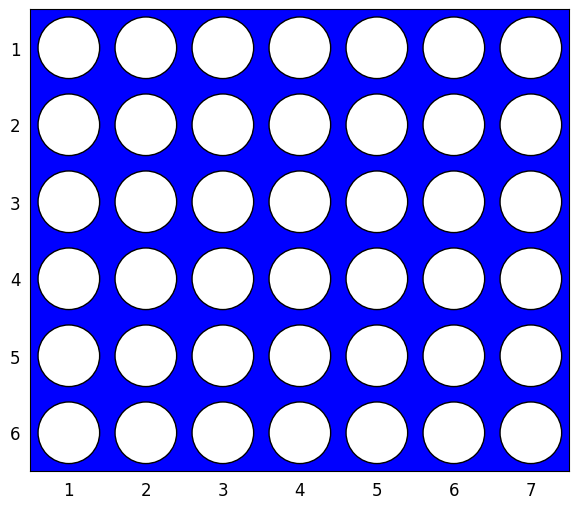

Which player would you like to be? Red or Yellow? Red goes first:  red
Please select your opponent: "CNN" or "Transformer" cnn


Your turn!


Pick a move (1-7): 4


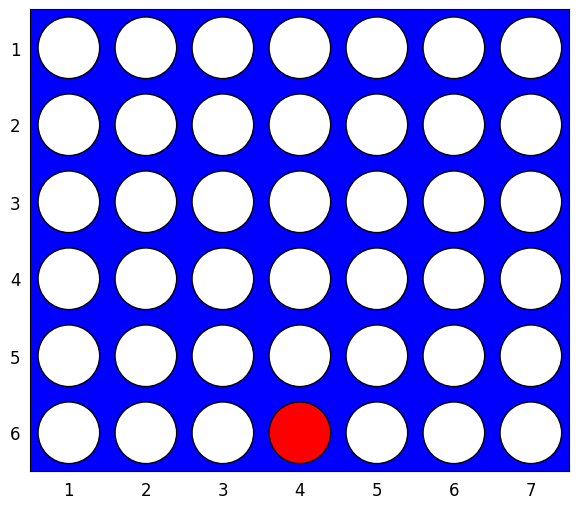

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Raw model output: [0.01007213 0.0306765  0.15021944 0.2967294  0.45004275 0.05914253
 0.00311731]
Winning move: -1
Nonlosing moves: [0, 1, 2, 3, 4, 5, 6]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Potential nonlosing moves: [0.01007213 0.0306765  0.15021944 0.2967294  0.45004275 0.05914253
 0.00311731]
Last move: 5


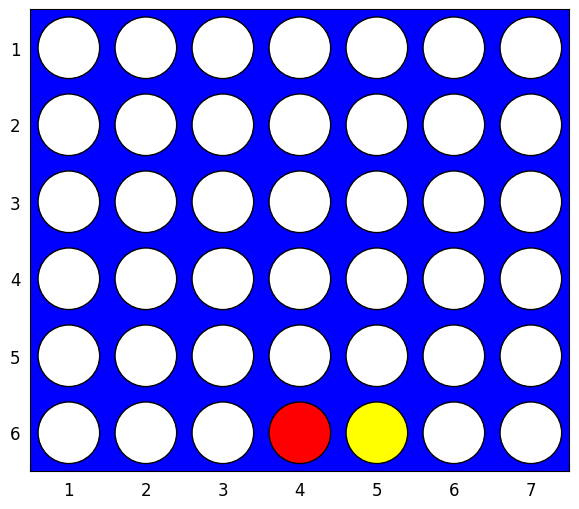

Your turn!


Pick a move (1-7): 3


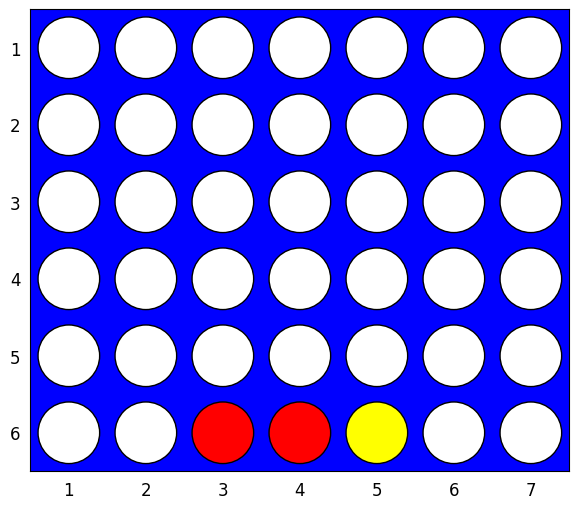

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Raw model output: [0.00188805 0.00053012 0.05354704 0.19194275 0.28202802 0.17980865
 0.2902554 ]
Winning move: -1
Nonlosing moves: [0, 1, 2, 3, 4, 5, 6]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Potential nonlosing moves: [0.00188805 0.00053012 0.05354704 0.19194275 0.28202802 0.17980865
 0.2902554 ]
Last move: 7


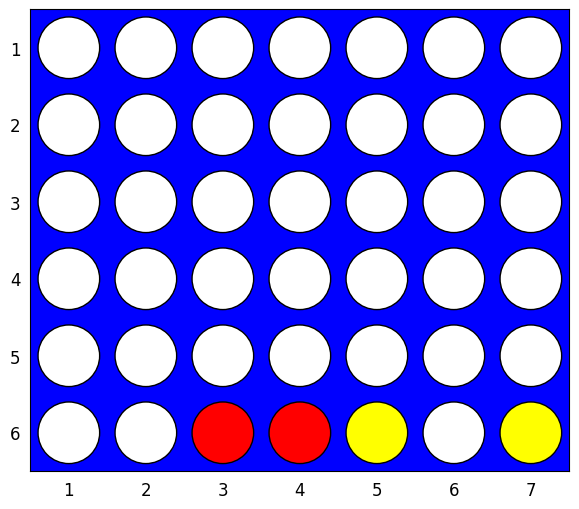

Your turn!


Pick a move (1-7): 2


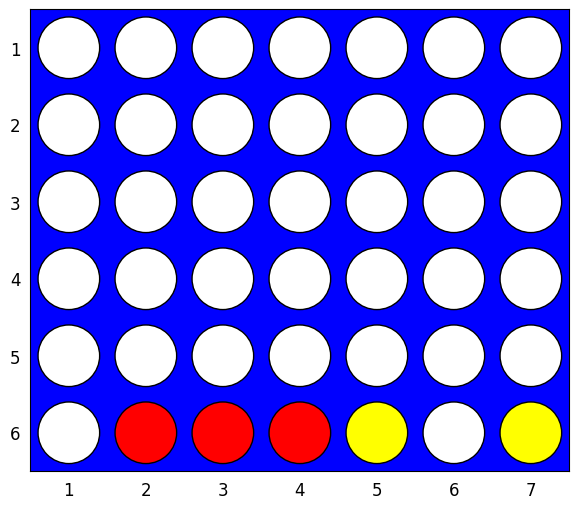

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Raw model output: [4.9218374e-06 4.8270863e-08 2.6664039e-04 1.1359510e-02 1.3210574e-03
 2.6751272e-04 9.8678035e-01]
Winning move: -1
Nonlosing moves: [0]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Potential nonlosing moves: [4.9218374e-06]
Last move: 1


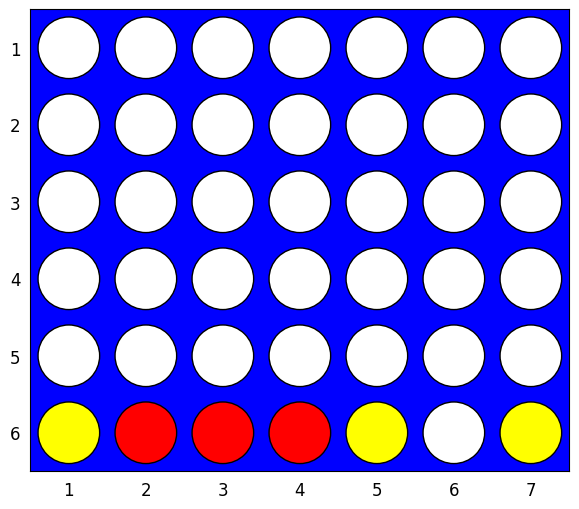

Your turn!


Pick a move (1-7): 4


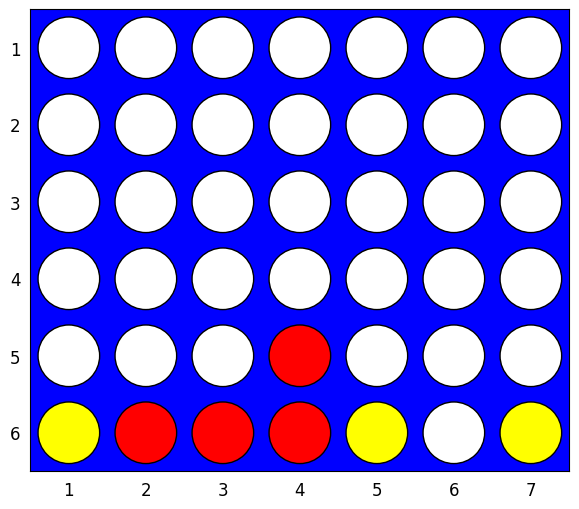

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Raw model output: [9.2363288e-04 1.7182429e-03 1.3327635e-02 4.8502284e-01 1.1822534e-01
 3.8043430e-01 3.4797669e-04]
Winning move: -1
Nonlosing moves: [0, 1, 2, 3, 4, 5, 6]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Potential nonlosing moves: [9.2363288e-04 1.7182429e-03 1.3327635e-02 4.8502284e-01 1.1822534e-01
 3.8043430e-01 3.4797669e-04]
Last move: 4


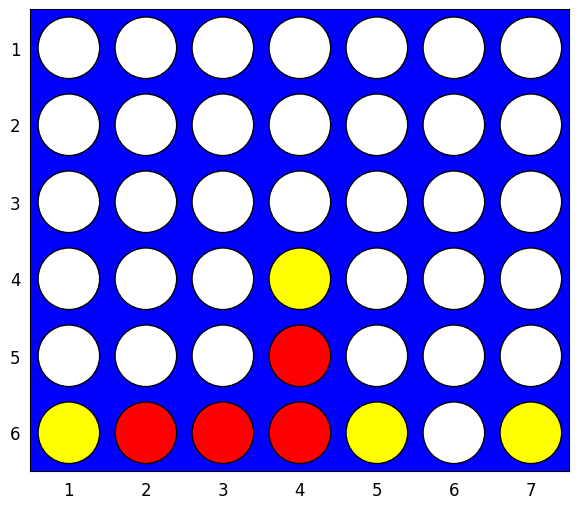

Your turn!


Pick a move (1-7): 5


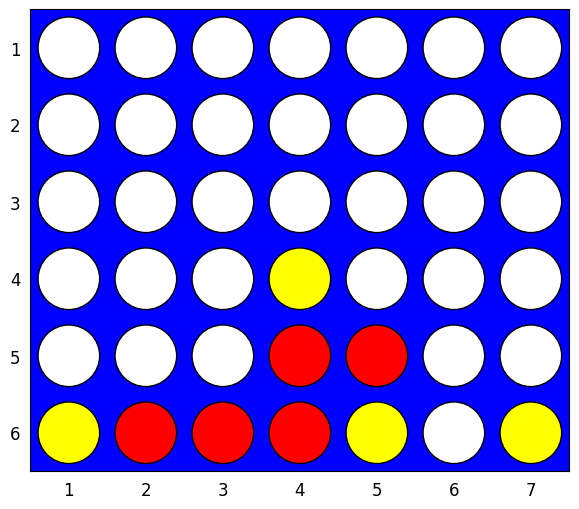

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Raw model output: [1.3599651e-03 8.3669831e-05 6.9274195e-02 7.0664799e-03 7.3385364e-01
 1.8802075e-01 3.4136587e-04]
Winning move: -1
Nonlosing moves: [0, 1, 2, 3, 4, 5, 6]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Potential nonlosing moves: [1.3599651e-03 8.3669831e-05 6.9274195e-02 7.0664799e-03 7.3385364e-01
 1.8802075e-01 3.4136587e-04]
Last move: 5


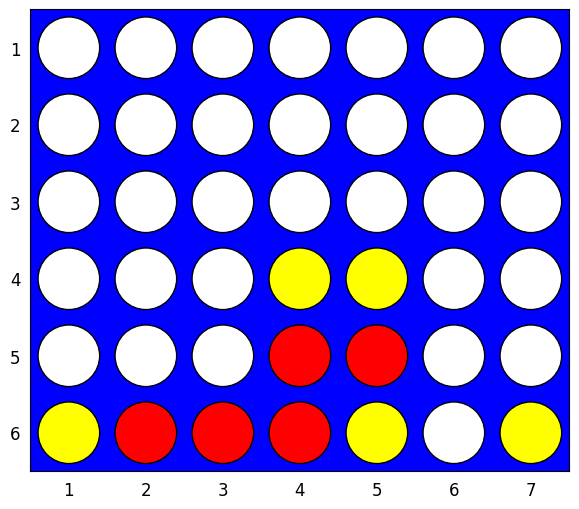

Your turn!


Pick a move (1-7): 4


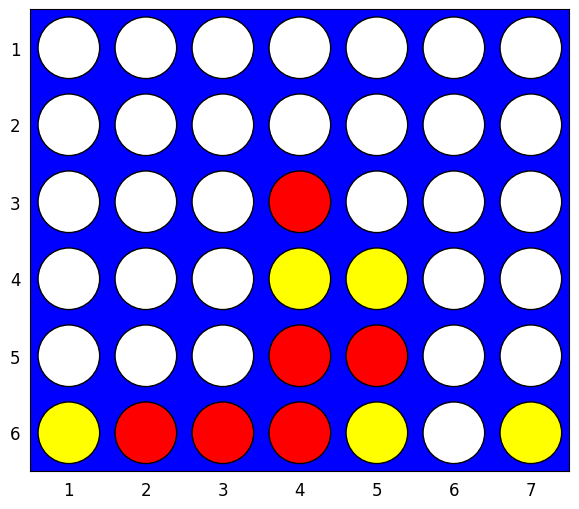

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Raw model output: [4.5789897e-02 2.7324499e-05 8.4342429e-04 1.4151903e-03 7.9322928e-01
 1.5174061e-01 6.9542043e-03]
Winning move: -1
Nonlosing moves: [0, 1, 2, 3, 4, 5, 6]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Potential nonlosing moves: [4.5789897e-02 2.7324499e-05 8.4342429e-04 1.4151903e-03 7.9322928e-01
 1.5174061e-01 6.9542043e-03]
Last move: 5


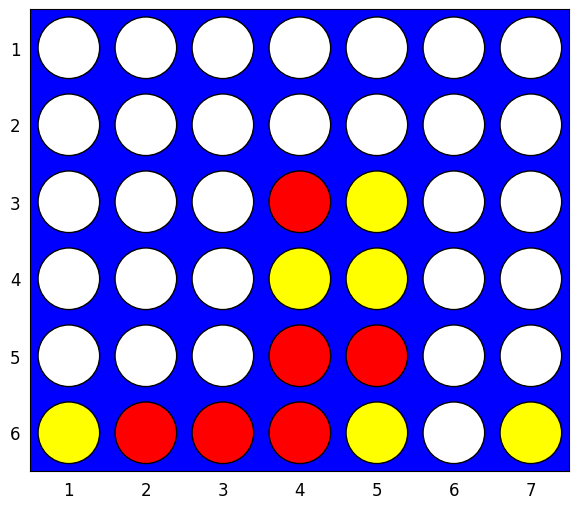

Your turn!


Pick a move (1-7): 7


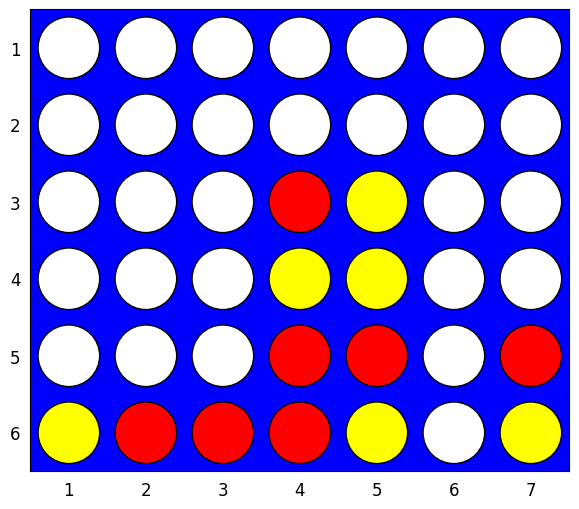

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Raw model output: [1.0018287e-03 3.7117559e-05 1.2704487e-01 2.9146957e-04 7.2017914e-01
 1.5034069e-01 1.1049439e-03]
Winning move: -1
Nonlosing moves: [0, 1, 2, 3, 4, 6]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Potential nonlosing moves: [1.0018287e-03 3.7117559e-05 1.2704487e-01 2.9146957e-04 7.2017914e-01
 1.1049439e-03]
Last move: 5


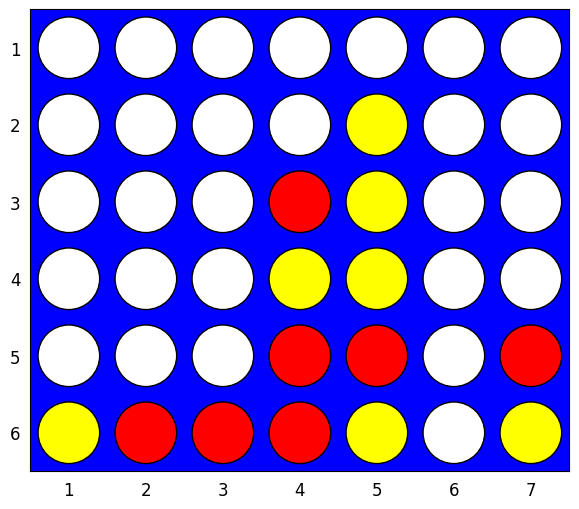

Your turn!


Pick a move (1-7): 5


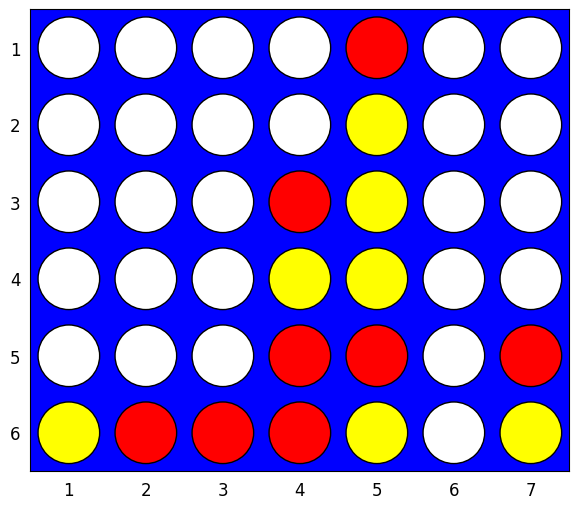

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Raw model output: [5.79216797e-03 1.77681268e-05 3.30220587e-06 2.09312697e-04
 7.39114046e-01 2.44310796e-01 1.05526885e-02]
Winning move: -1
Nonlosing moves: [0, 1, 2, 3, 6]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Potential nonlosing moves: [5.79216797e-03 1.77681268e-05 3.30220587e-06 2.09312697e-04
 1.05526885e-02]
Last move: 7


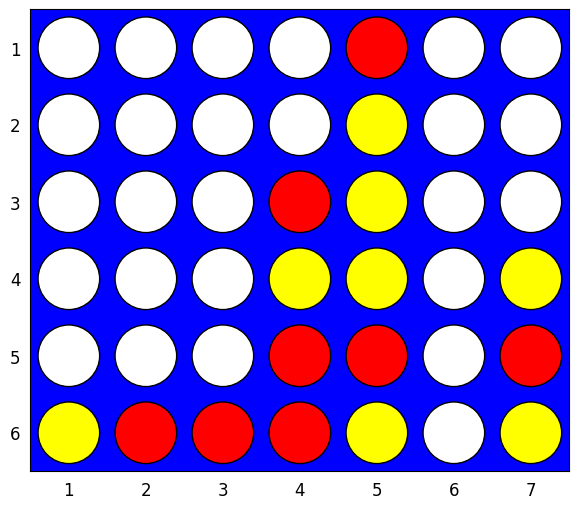

Your turn!


Pick a move (1-7): 4


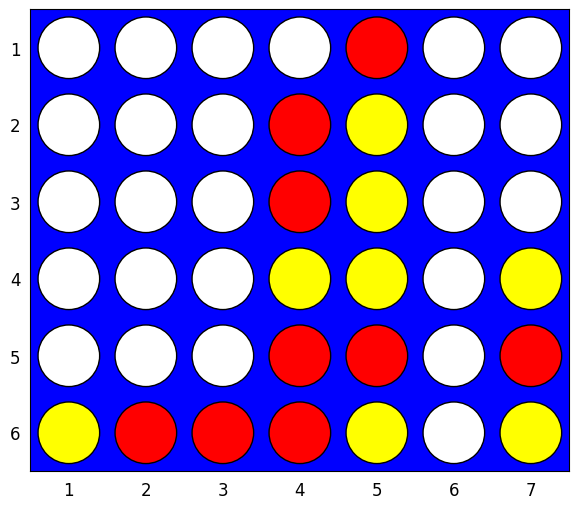

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Raw model output: [7.3587889e-04 3.3555091e-06 2.5136519e-06 2.3995362e-06 9.2266846e-01
 6.9030441e-02 7.5568631e-03]
Winning move: -1
Nonlosing moves: [0, 1, 2, 3, 6]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Potential nonlosing moves: [7.3587889e-04 3.3555091e-06 2.5136519e-06 2.3995362e-06 7.5568631e-03]
Last move: 7


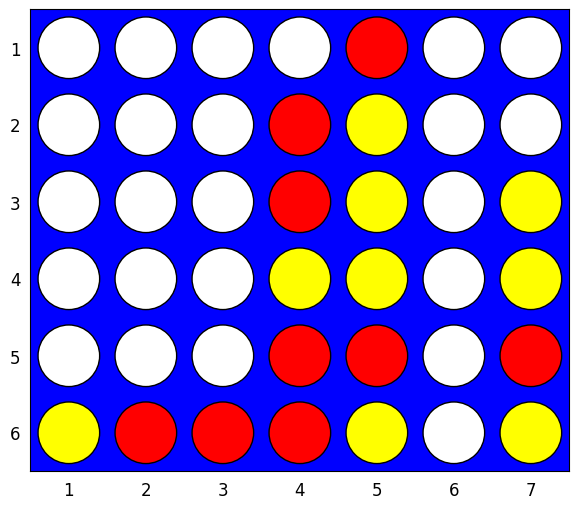

Your turn!


Pick a move (1-7): 1


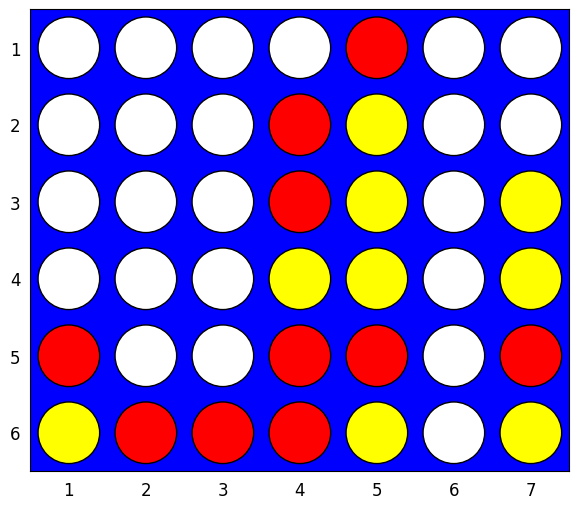

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Raw model output: [3.8044024e-03 2.6380889e-07 9.7228234e-09 9.4643309e-07 9.8646045e-01
 9.6003721e-03 1.3356650e-04]
Winning move: -1
Nonlosing moves: [0, 1, 2, 3, 6]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Potential nonlosing moves: [3.8044024e-03 2.6380889e-07 9.7228234e-09 9.4643309e-07 1.3356650e-04]
Last move: 1


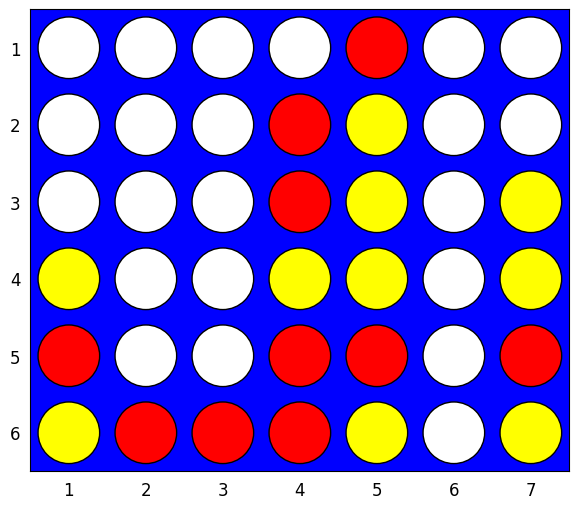

Your turn!


Pick a move (1-7): 3


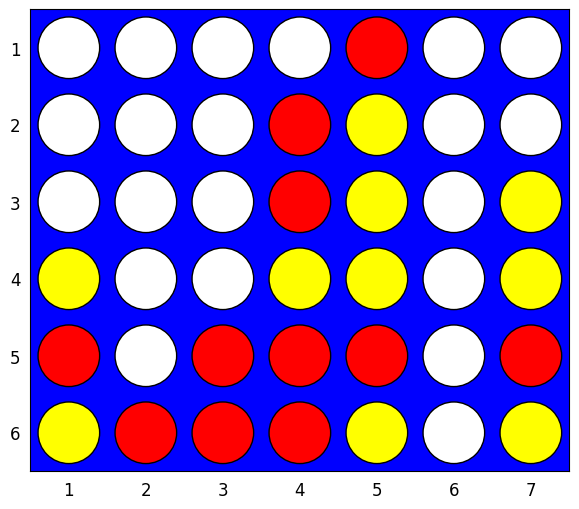

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Raw model output: [1.1963928e-03 2.4655935e-06 2.2798783e-09 9.3100404e-08 1.2769794e-06
 9.9858510e-01 2.1457742e-04]
Winning move: -1
Nonlosing moves: [1]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Potential nonlosing moves: [2.4655935e-06]
Last move: 2


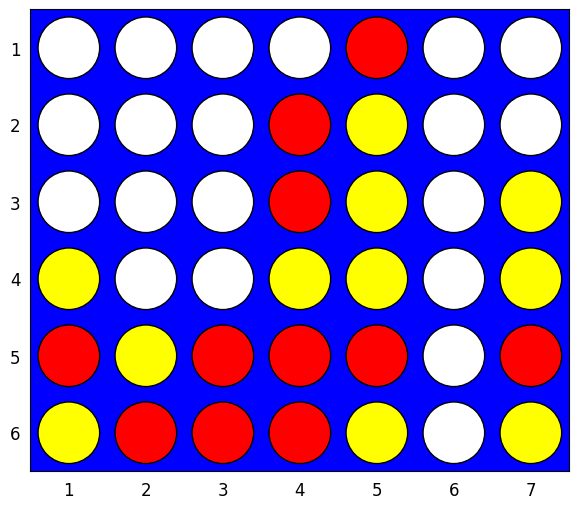

Your turn!


Pick a move (1-7): 2


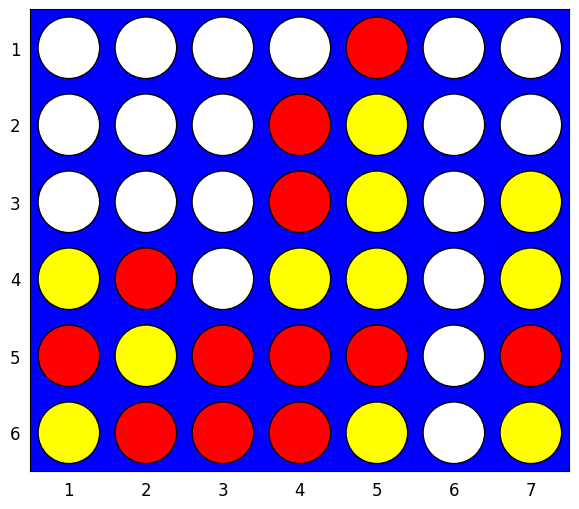

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Raw model output: [6.2305033e-01 1.1999325e-02 2.2416167e-04 3.4353824e-04 3.5610382e-04
 1.1285152e-01 2.5117508e-01]
Winning move: -1
Nonlosing moves: [0]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Potential nonlosing moves: [0.62305033]
Last move: 1


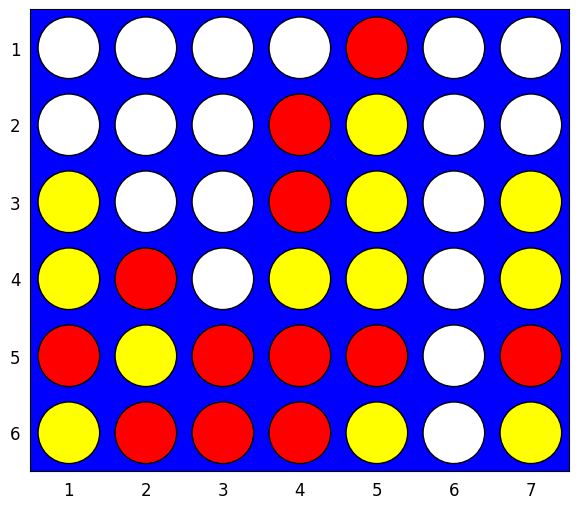

Your turn!


Pick a move (1-7): 2


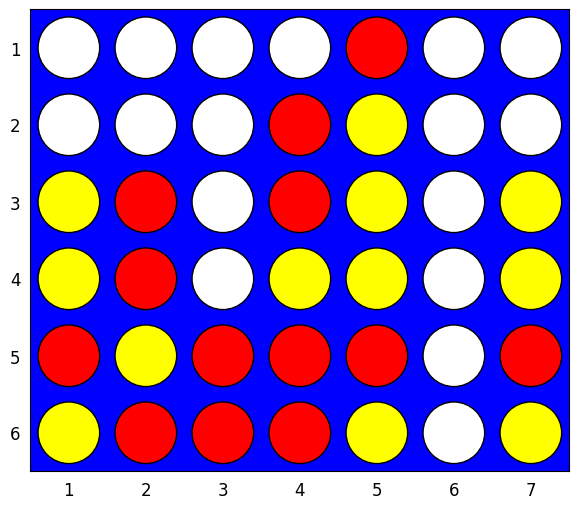

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Raw model output: [1.0599019e-01 2.8235698e-05 2.1630198e-07 1.6539899e-06 1.4910789e-01
 1.7271943e-02 7.2759986e-01]
Winning move: -1
Nonlosing moves: [0, 1, 3, 6]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Potential nonlosing moves: [1.0599019e-01 2.8235698e-05 1.6539899e-06 7.2759986e-01]
Last move: 7


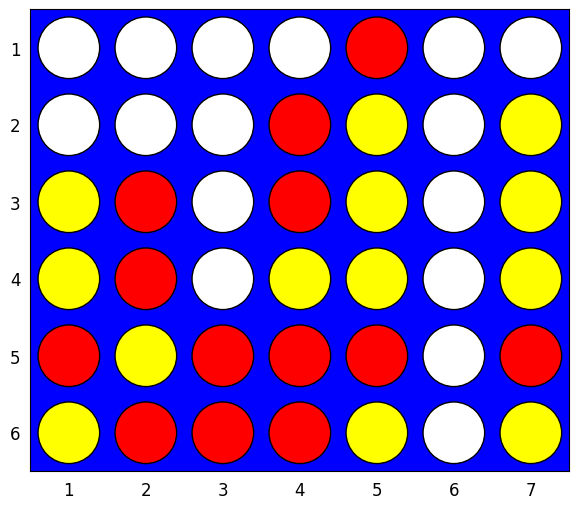

Your turn!


Pick a move (1-7): 7


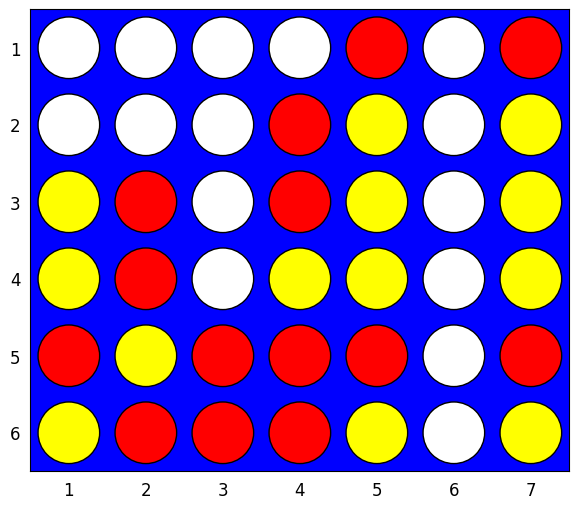

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Raw model output: [3.5379987e-06 1.2096068e-04 4.2415820e-07 1.4592549e-06 2.6113546e-01
 2.8213665e-02 7.1052450e-01]
Winning move: -1
Nonlosing moves: [0, 1, 3]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Potential nonlosing moves: [3.5379987e-06 1.2096068e-04 1.4592549e-06]
Last move: 2


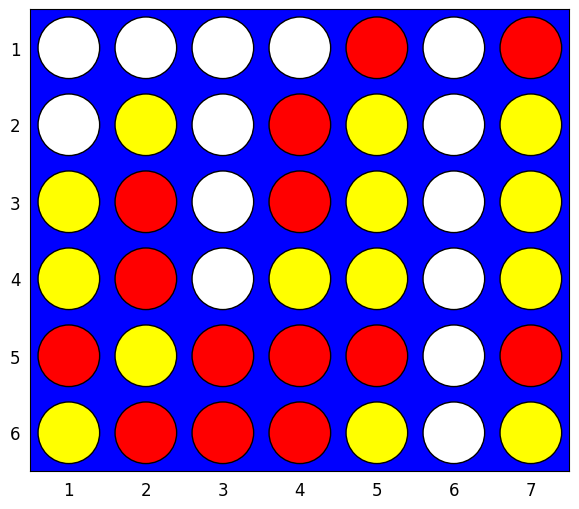

Your turn!


Pick a move (1-7): 4


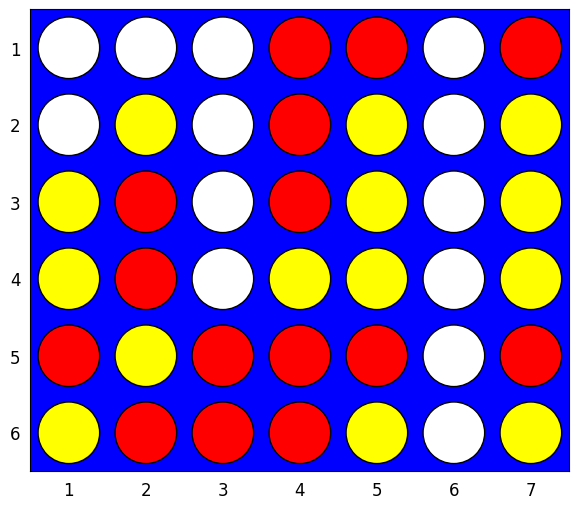

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Raw model output: [5.5455217e-05 4.2443164e-02 1.8964587e-06 7.3549717e-07 3.6580801e-01
 7.6491065e-02 5.1519966e-01]
Winning move: -1
Nonlosing moves: [0, 1]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Potential nonlosing moves: [5.5455217e-05 4.2443164e-02]
Last move: 2


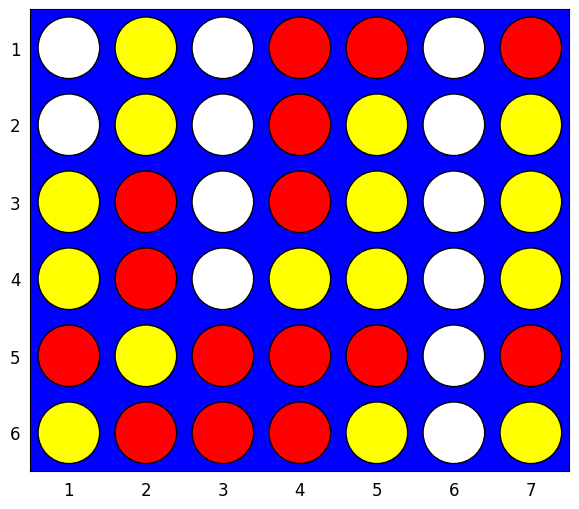

Your turn!


Pick a move (1-7): 1


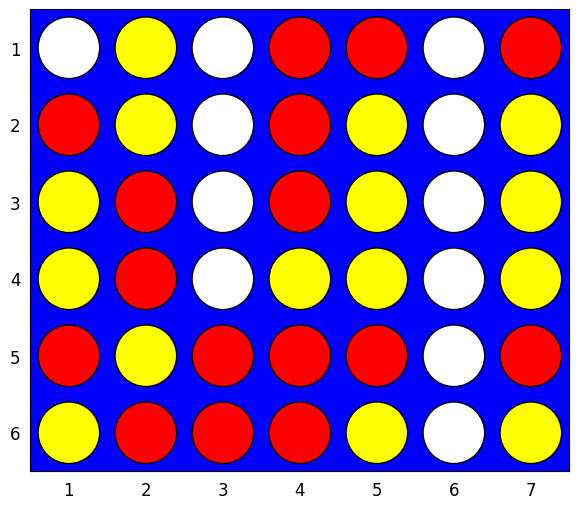

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Raw model output: [5.4596789e-08 1.1067693e-02 5.2773848e-06 1.9249500e-08 9.6766192e-01
 1.2101408e-09 2.1264933e-02]
Winning move: -1
Nonlosing moves: []
Can't block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Potential moves: [5.4596789e-08 5.2773848e-06 1.2101408e-09]
Column 1 is full. Please select a different column.


In [ ]:
# With win and block logic added
# Bot can also only play legal moves (just in case it tries to play in a full column)

# Set up new game
winner = 'nobody'
board = np.zeros((6,7,2))
plot_connect4(board)
player = 'red'

# Determine which color each player is (red goes first)
while True:
    human_player = input("Which player would you like to be? Red or Yellow? Red goes first: ").strip().lower()
    if human_player in ['red', 'yellow']:
        bot_player = 'yellow' if human_player == 'red' else 'red'
        break  # Exit loop if input is valid
    else:
        print("Invalid choice. Please enter 'Red' or 'Yellow'.")

# Determine which model to use
selected_opponent = input('Please select your opponent: "CNN" or "Transformer"').strip().lower()
if selected_opponent == 'cnn':
    # Because I had an issue loading the model
    custom_objects = {
        'softmax_v2': tf.keras.activations.softmax
    }
    model = load_model('best_connect4_cnn.h5', custom_objects=custom_objects)
else:
    model = load_model('best_transformer.h5')


while winner == 'nobody':
    # Check for legal moves, else return 'tie'
    legal = find_legal(board)
    if len(legal) == 0:
        winner = 'tie'
        break
    
    if player == human_player:
        print('Your turn!')
        move = input('Pick a move (1-7):')
        move = int(move) - 1 # convert player's move to index
        board = update_board(board,human_player,move)
        clear_output()
        plot_connect4(board)

    elif player != human_player:
        print('Bot is thinking...')
        
        # If bot is yellow, flip board for accurate predictions
        if bot_player == 'yellow':
            move = look_for_win(board,bot_player)
            # Ignore model predictions and select winning move if there is one
            if move > -0.5:
                board = update_board(board,bot_player,move)
            # Ensure you block a win on the next turn, even if model doesn't select that move
            else:
                nonlosing_moves = find_all_nonlosers(board,bot_player) # only play nonlosing moves
                if len(nonlosing_moves) == 0: # if you can't block (there are two moves where your opponent will win)
                    temp_board = np.flip(board, axis = 1) # don't want to actually save this board, just used for predictions
                    model_input = np.expand_dims(temp_board, axis=0) # need to include an extra dimension for sample size = 1
                    legal_moves = find_legal(board)
                    bot_moves = model.predict(model_input)[0][legal_moves] # just get the highest probability move
                    pick_of_legal = np.argmax(bot_moves)
                    move = legal_moves[pick_of_legal]
                    board = update_board(board,bot_player,move)
                else: # if you can block or don't need to block
                    temp_board = np.flip(board, axis = 1) # don't want to actually save this board, just used for predictions
                    model_input = np.expand_dims(temp_board, axis=0) # need to include an extra dimension for sample size = 1
                    bot_moves = model.predict(model_input)[0][nonlosing_moves] # extract the probabilities for nonlosing moves
                    pick_of_nonlosing = np.argmax(bot_moves)
                    move = nonlosing_moves[pick_of_nonlosing]
                    board = update_board(board,bot_player,move)
        else:
            move = look_for_win(board,bot_player)
            # ignore model predictions and select winning move if there is one
            if move > -0.5:
                board = update_board(board,bot_player,move)
            # Ensure you block a win on the next turn, even if model doesn't select that move
            else:
                model_input = np.expand_dims(board, axis=0) # need to include an extra dimension for sample size = 1
                nonlosing_moves = find_all_nonlosers(board, bot_player)
                if len(nonlosing_moves) == 0: # if you can't block (there are two moves where your opponent will win)
                    legal_moves = find_legal(board)
                    bot_moves = model.predict(model_input)[0][legal_moves]
                    pick_of_legal = np.argmax(bot_moves)
                    move = legal_moves[pick_of_legal]
                    board = update_board(board,bot_player,move)
                else: # if you can block or don't need to block
                    bot_moves = model.predict(model_input)[0][nonlosing_moves] # extract the probabilities for nonlosing moves
                    pick_of_nonlosing = np.argmax(bot_moves)
                    move = nonlosing_moves[pick_of_nonlosing]
                    board = update_board(board,bot_player,move)
        clear_output()
        print(f'Last bot move: {move+1}')
        plot_connect4(board)
        
    # Check for a win after either player plays
    winner = check_for_win(board,move)

    # Switch players and go onto the next turn if no one has won
    if player == 'red':
        player = 'yellow'
    else:
        player = 'red'

print('The winner is '+winner)

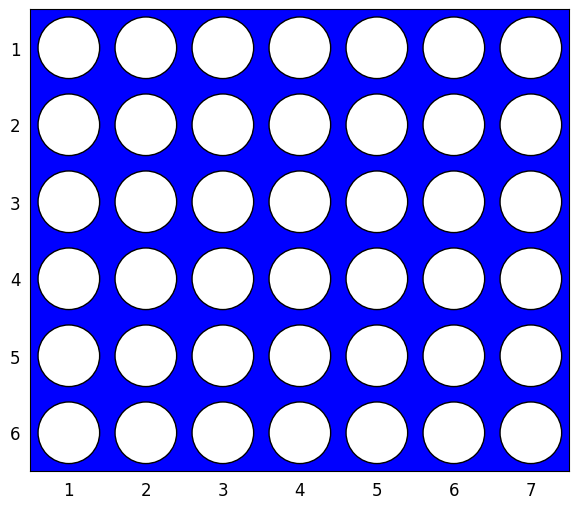

Which player would you like to be? Red or Yellow? Red goes first:  red
Please select your opponent: "CNN" or "Transformer" cnn


Your turn!


Pick a move (1-7): 4


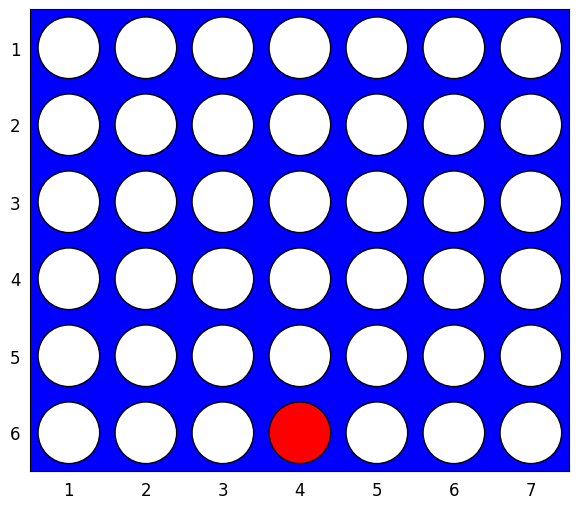

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Raw model output: [0.01007213 0.0306765  0.15021944 0.2967294  0.45004275 0.05914253
 0.00311731]
Winning move: -1
Nonlosing moves: [0, 1, 2, 3, 4, 5, 6]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Potential nonlosing moves: [0.01007213 0.0306765  0.15021944 0.2967294  0.45004275 0.05914253
 0.00311731]
Last move: 5


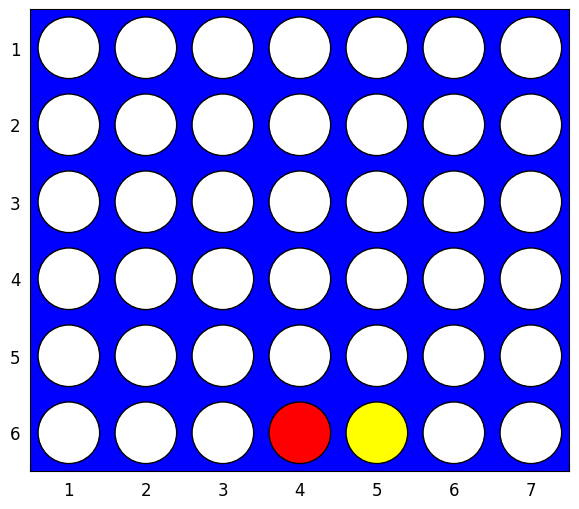

Your turn!


Pick a move (1-7): 3


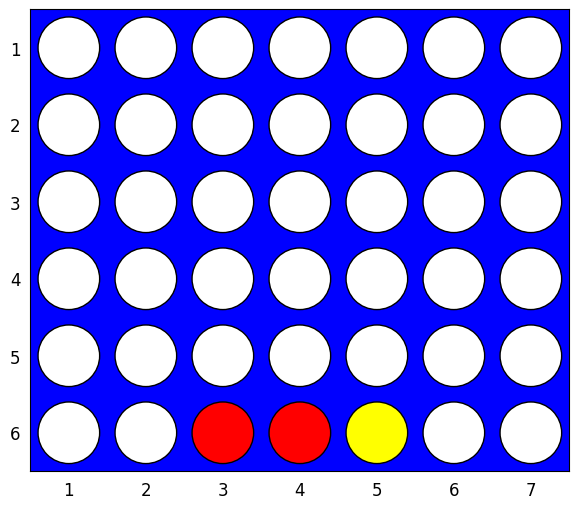

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Raw model output: [0.00188805 0.00053012 0.05354704 0.19194275 0.28202802 0.17980865
 0.2902554 ]
Winning move: -1
Nonlosing moves: [0, 1, 2, 3, 4, 5, 6]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Potential nonlosing moves: [0.00188805 0.00053012 0.05354704 0.19194275 0.28202802 0.17980865
 0.2902554 ]
Last move: 7


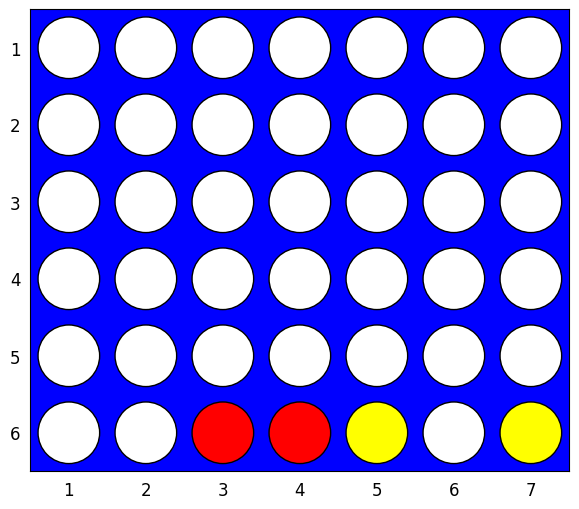

Your turn!


Pick a move (1-7): 2


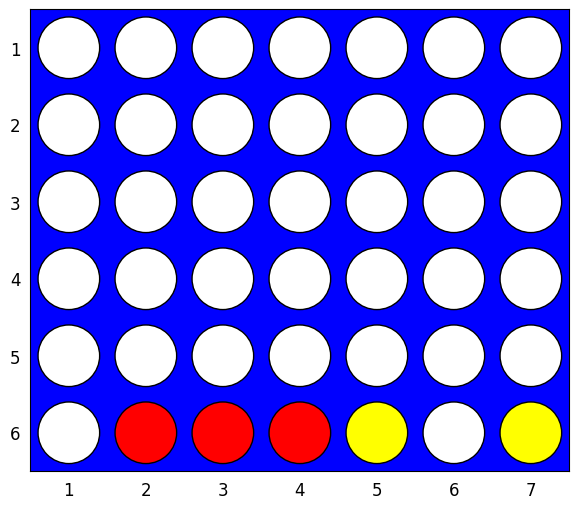

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Raw model output: [4.9218374e-06 4.8270863e-08 2.6664039e-04 1.1359510e-02 1.3210574e-03
 2.6751272e-04 9.8678035e-01]
Winning move: -1
Nonlosing moves: [0]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Potential nonlosing moves: [4.9218374e-06]
Last move: 1


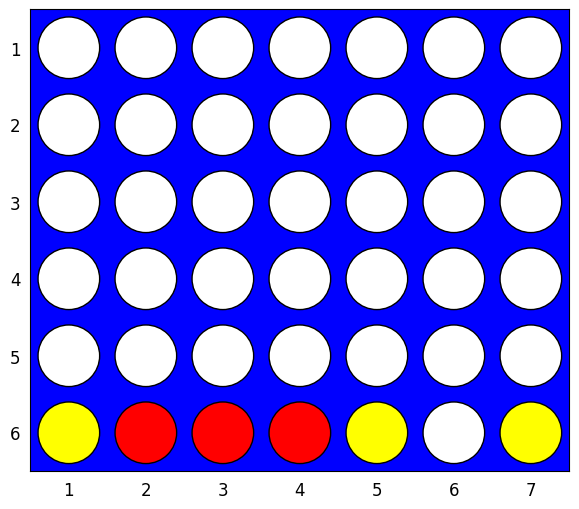

Your turn!


Pick a move (1-7): 4


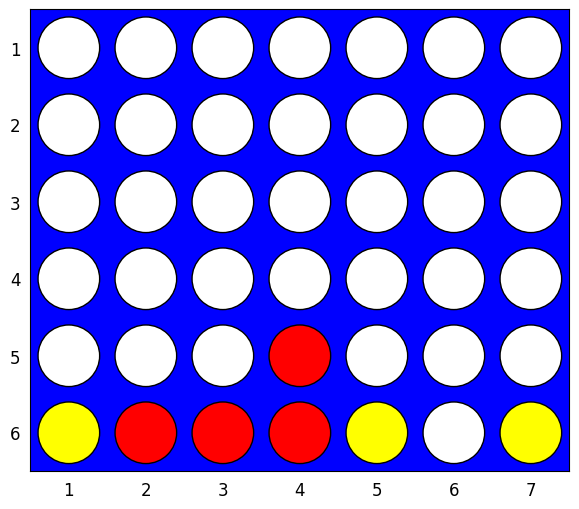

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Raw model output: [9.2363288e-04 1.7182429e-03 1.3327635e-02 4.8502284e-01 1.1822534e-01
 3.8043430e-01 3.4797669e-04]
Winning move: -1
Nonlosing moves: [0, 1, 2, 3, 4, 5, 6]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Potential nonlosing moves: [9.2363288e-04 1.7182429e-03 1.3327635e-02 4.8502284e-01 1.1822534e-01
 3.8043430e-01 3.4797669e-04]
Last move: 4


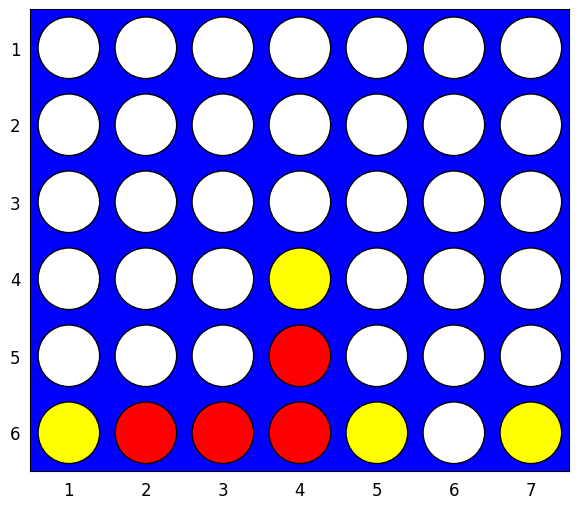

Your turn!


Pick a move (1-7): 5


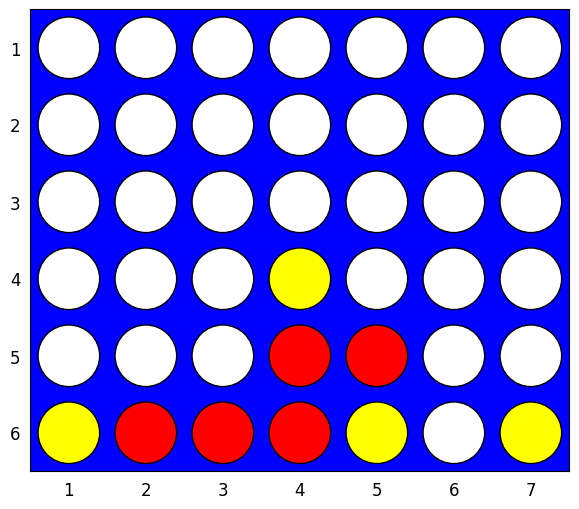

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Raw model output: [1.3599651e-03 8.3669831e-05 6.9274195e-02 7.0664799e-03 7.3385364e-01
 1.8802075e-01 3.4136587e-04]
Winning move: -1
Nonlosing moves: [0, 1, 2, 3, 4, 5, 6]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Potential nonlosing moves: [1.3599651e-03 8.3669831e-05 6.9274195e-02 7.0664799e-03 7.3385364e-01
 1.8802075e-01 3.4136587e-04]
Last move: 5


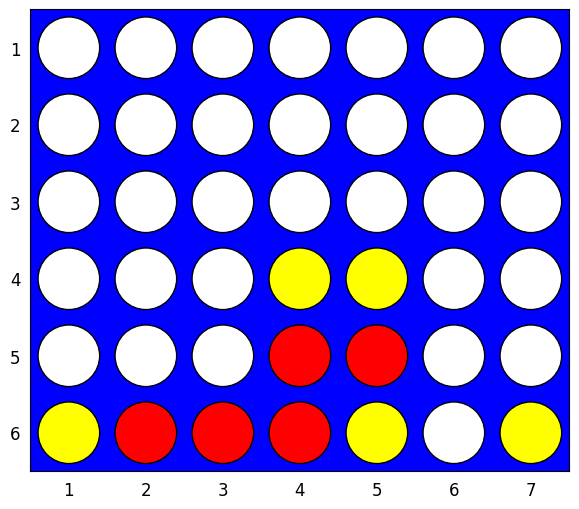

Your turn!


Pick a move (1-7): 4


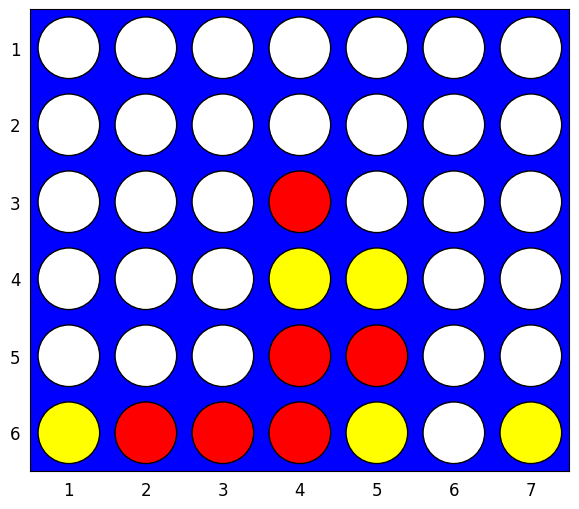

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Raw model output: [4.5789897e-02 2.7324499e-05 8.4342429e-04 1.4151903e-03 7.9322928e-01
 1.5174061e-01 6.9542043e-03]
Winning move: -1
Nonlosing moves: [0, 1, 2, 3, 4, 5, 6]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Potential nonlosing moves: [4.5789897e-02 2.7324499e-05 8.4342429e-04 1.4151903e-03 7.9322928e-01
 1.5174061e-01 6.9542043e-03]
Last move: 5


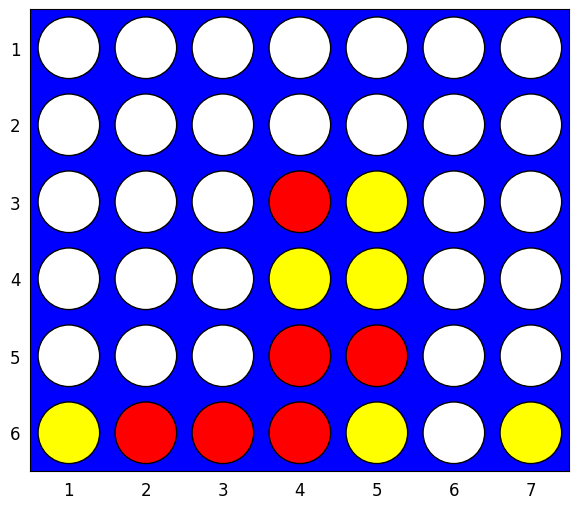

Your turn!


Pick a move (1-7): 7


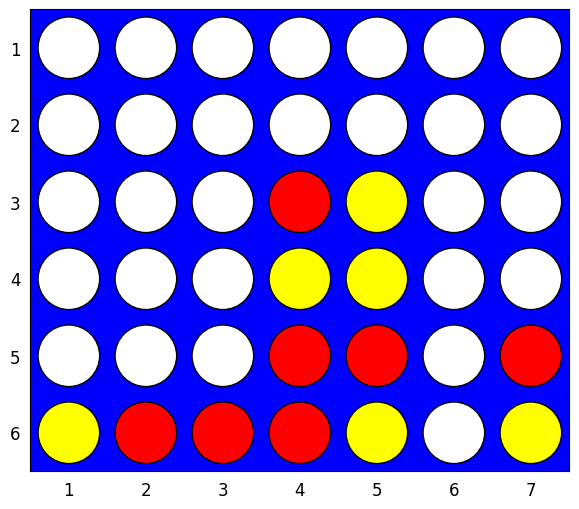

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Raw model output: [1.0018287e-03 3.7117559e-05 1.2704487e-01 2.9146957e-04 7.2017914e-01
 1.5034069e-01 1.1049439e-03]
Winning move: -1
Nonlosing moves: [0, 1, 2, 3, 4, 6]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Potential nonlosing moves: [1.0018287e-03 3.7117559e-05 1.2704487e-01 2.9146957e-04 7.2017914e-01
 1.1049439e-03]
Last move: 5


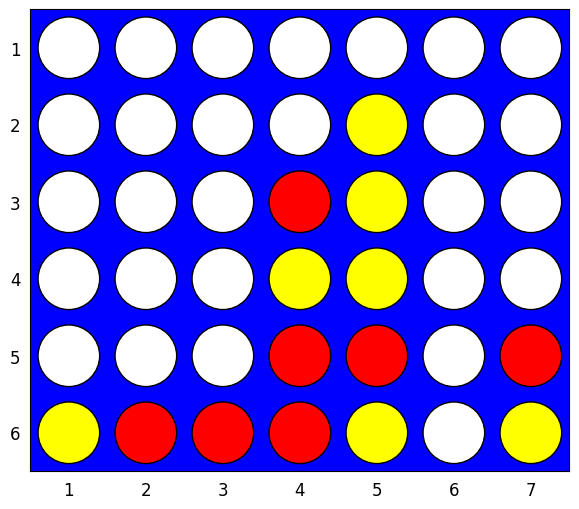

Your turn!


Pick a move (1-7): 5


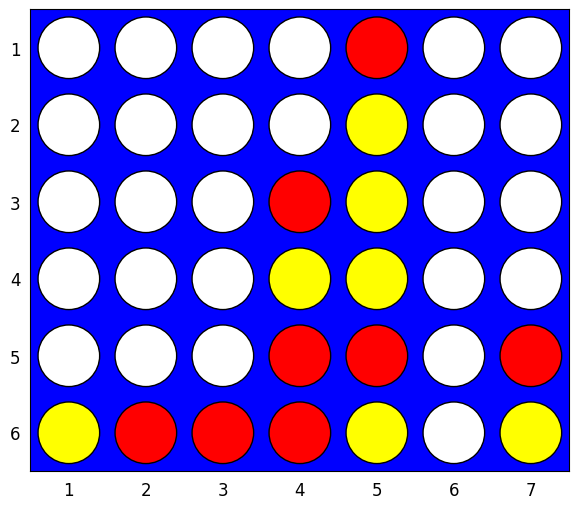

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Raw model output: [5.79216797e-03 1.77681268e-05 3.30220587e-06 2.09312697e-04
 7.39114046e-01 2.44310796e-01 1.05526885e-02]
Winning move: -1
Nonlosing moves: [0, 1, 2, 3, 6]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Potential nonlosing moves: [5.79216797e-03 1.77681268e-05 3.30220587e-06 2.09312697e-04
 1.05526885e-02]
Last move: 7


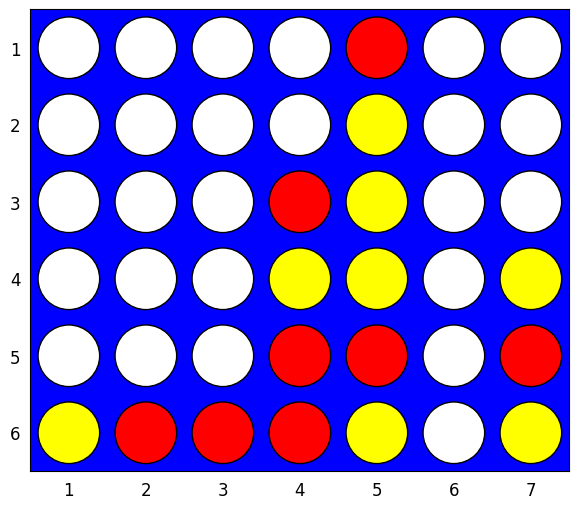

Your turn!


Pick a move (1-7): 4


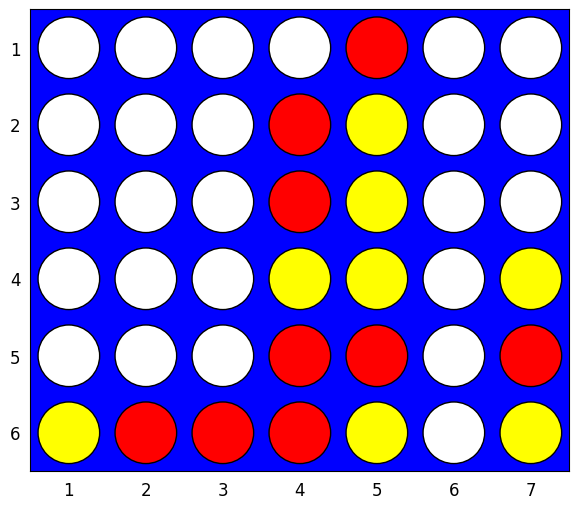

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Raw model output: [7.3587889e-04 3.3555091e-06 2.5136519e-06 2.3995362e-06 9.2266846e-01
 6.9030441e-02 7.5568631e-03]
Winning move: -1
Nonlosing moves: [0, 1, 2, 3, 6]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Potential nonlosing moves: [7.3587889e-04 3.3555091e-06 2.5136519e-06 2.3995362e-06 7.5568631e-03]
Last move: 7


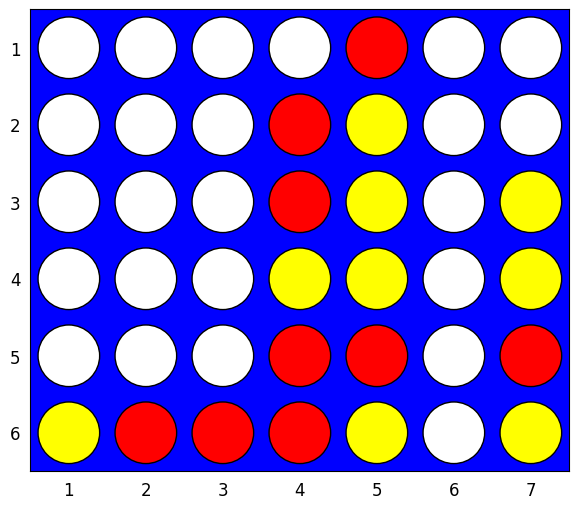

Your turn!


Pick a move (1-7): 1


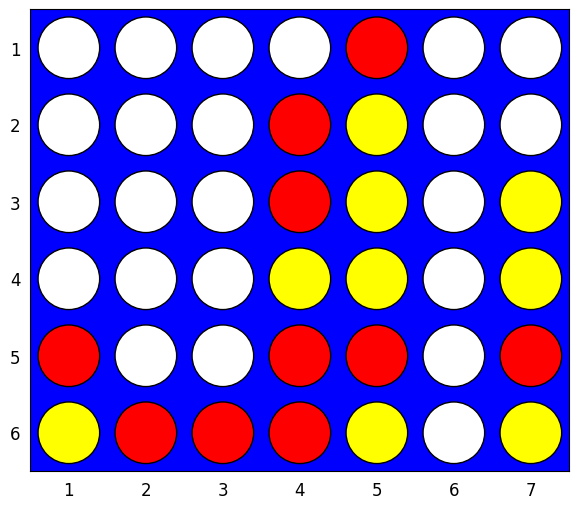

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Raw model output: [3.8044024e-03 2.6380889e-07 9.7228234e-09 9.4643309e-07 9.8646045e-01
 9.6003721e-03 1.3356650e-04]
Winning move: -1
Nonlosing moves: [0, 1, 2, 3, 6]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Potential nonlosing moves: [3.8044024e-03 2.6380889e-07 9.7228234e-09 9.4643309e-07 1.3356650e-04]
Last move: 1


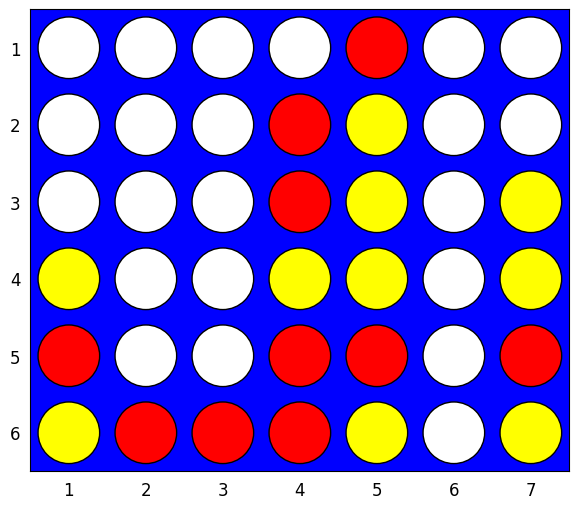

Your turn!


Pick a move (1-7): 3


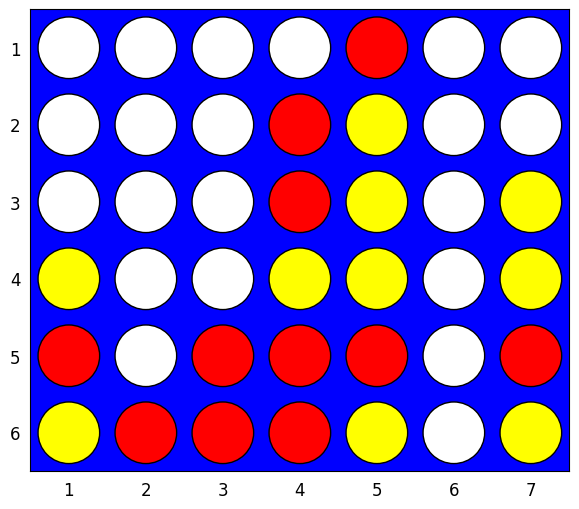

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Raw model output: [1.1963928e-03 2.4655935e-06 2.2798783e-09 9.3100404e-08 1.2769794e-06
 9.9858510e-01 2.1457742e-04]
Winning move: -1
Nonlosing moves: [1]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Potential nonlosing moves: [2.4655935e-06]
Last move: 2


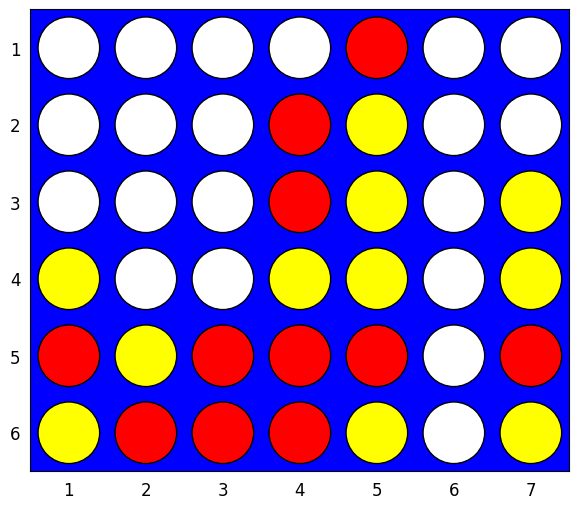

Your turn!


Pick a move (1-7): 2


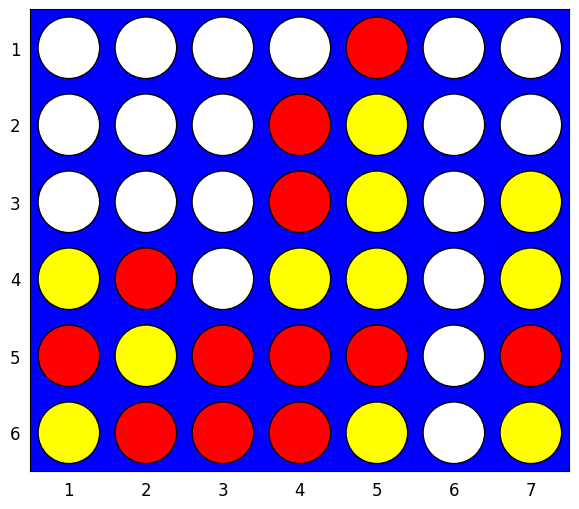

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Raw model output: [6.2305033e-01 1.1999325e-02 2.2416167e-04 3.4353824e-04 3.5610382e-04
 1.1285152e-01 2.5117508e-01]
Winning move: -1
Nonlosing moves: [0]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Potential nonlosing moves: [0.62305033]
Last move: 1


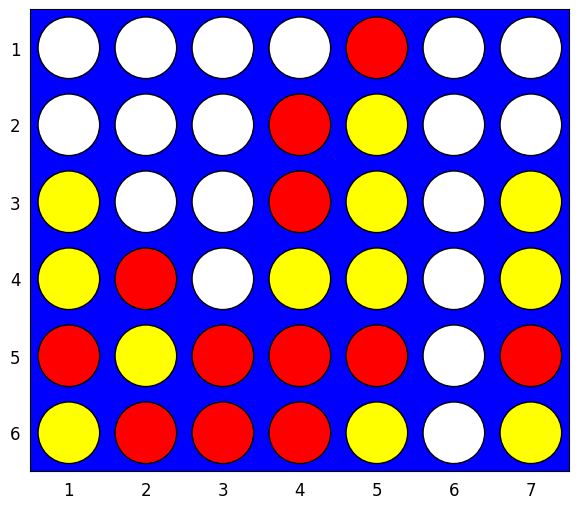

Your turn!


Pick a move (1-7): 2


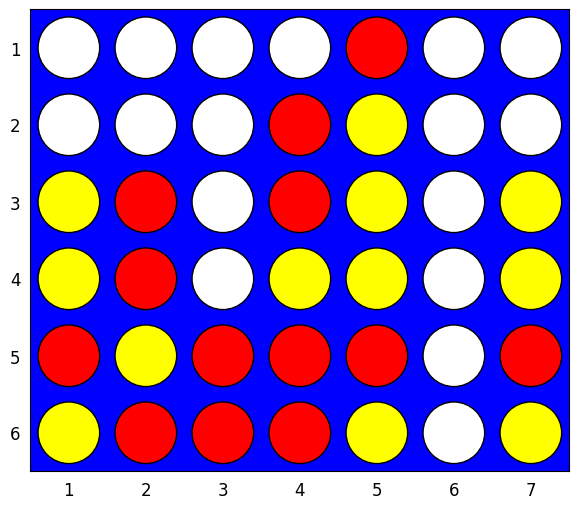

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Raw model output: [1.0599019e-01 2.8235698e-05 2.1630198e-07 1.6539899e-06 1.4910789e-01
 1.7271943e-02 7.2759986e-01]
Winning move: -1
Nonlosing moves: [0, 1, 3, 6]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Potential nonlosing moves: [1.0599019e-01 2.8235698e-05 1.6539899e-06 7.2759986e-01]
Last move: 7


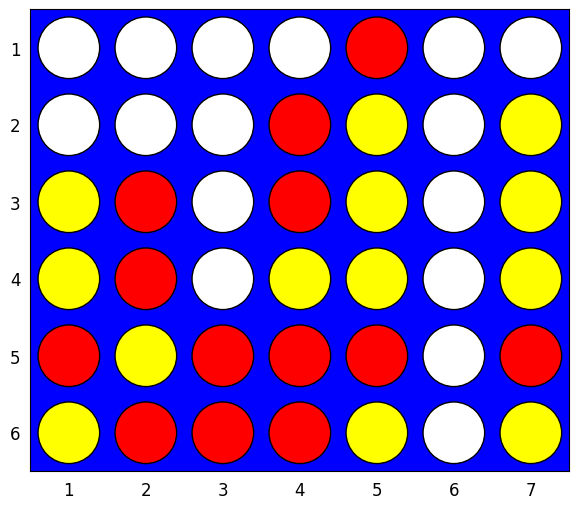

Your turn!


Pick a move (1-7): 7


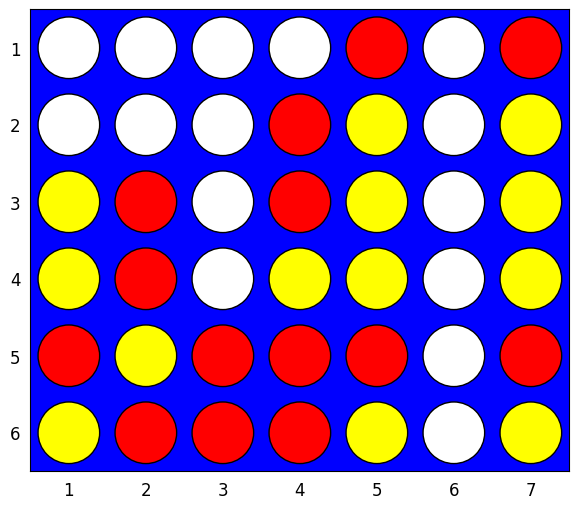

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Raw model output: [3.5379987e-06 1.2096068e-04 4.2415820e-07 1.4592549e-06 2.6113546e-01
 2.8213665e-02 7.1052450e-01]
Winning move: -1
Nonlosing moves: [0, 1, 3]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Potential nonlosing moves: [3.5379987e-06 1.2096068e-04 1.4592549e-06]
Last move: 2


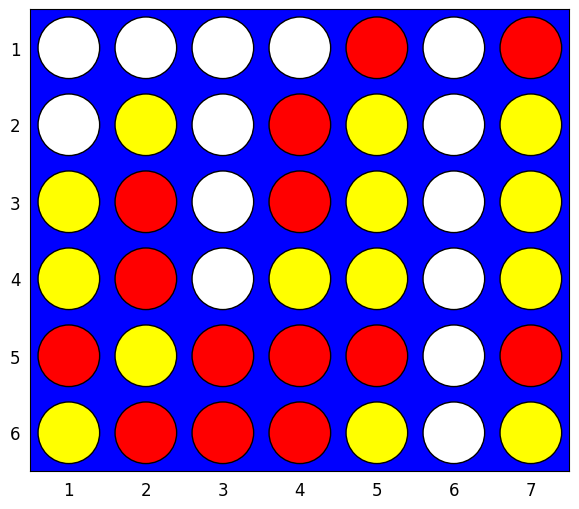

Your turn!


Pick a move (1-7): 4


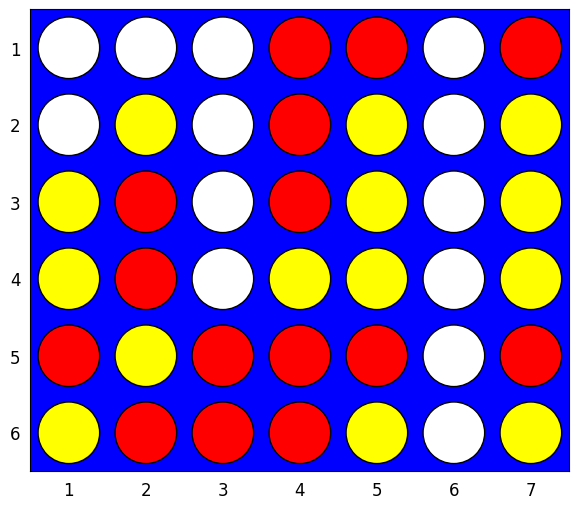

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Raw model output: [5.5455217e-05 4.2443164e-02 1.8964587e-06 7.3549717e-07 3.6580801e-01
 7.6491065e-02 5.1519966e-01]
Winning move: -1
Nonlosing moves: [0, 1]
Can or don't need to block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Potential nonlosing moves: [5.5455217e-05 4.2443164e-02]
Last move: 2


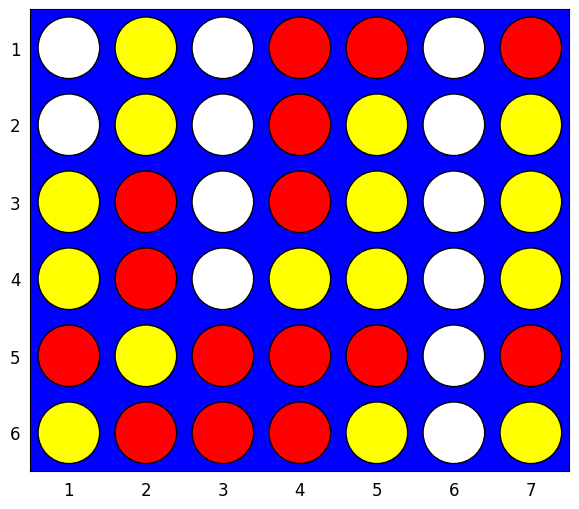

Your turn!


Pick a move (1-7): 1


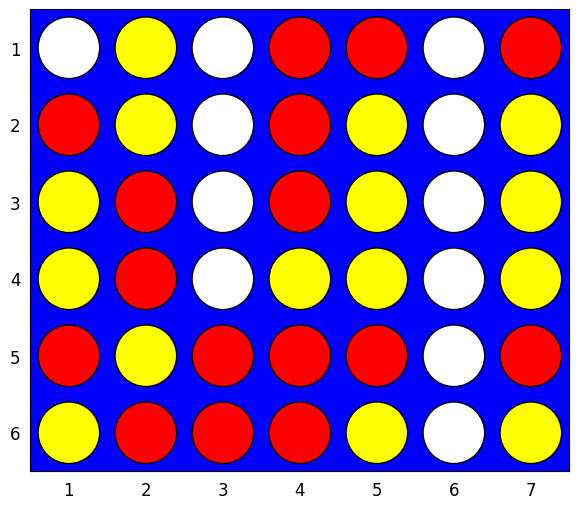

Bot is thinking...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Raw model output: [5.4596789e-08 1.1067693e-02 5.2773848e-06 1.9249500e-08 9.6766192e-01
 1.2101408e-09 2.1264933e-02]
Winning move: -1
Nonlosing moves: []
Can't block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Potential moves: [5.4596789e-08 5.2773848e-06 1.2101408e-09]
Column 1 is full. Please select a different column.


In [ ]:
# # With print statements for testing an examining game
# # With win and block logic added
# # Bot can also only play legal moves (just in case it tries to play in a full column)

# # Set up new game
# winner = 'nobody'
# board = np.zeros((6,7,2))
# plot_connect4(board)
# player = 'red'

# # Determine which color each player is (red goes first)
# while True:
#     human_player = input("Which player would you like to be? Red or Yellow? Red goes first: ").strip().lower()
#     if human_player in ['red', 'yellow']:
#         bot_player = 'yellow' if human_player == 'red' else 'red'
#         break  # Exit loop if input is valid
#     else:
#         print("Invalid choice. Please enter 'Red' or 'Yellow'.")

# # Determine which model to use
# selected_opponent = input('Please select your opponent: "CNN" or "Transformer"').strip().lower()
# if selected_opponent == 'cnn':
#     # Because I had an issue loading the model
#     custom_objects = {
#         'softmax_v2': tf.keras.activations.softmax
#     }
#     model = load_model('best_connect4_cnn.h5', custom_objects=custom_objects)
# else:
#     model = load_model('best_transformer.h5')


# while winner == 'nobody':
#     # Check for legal moves, else return 'tie'
#     legal = find_legal(board)
#     if len(legal) == 0:
#         winner = 'tie'
#         break
    
#     if player == human_player:
#         print('Your turn!')
#         move = input('Pick a move (1-7):')
#         move = int(move) - 1 # convert player's move to index
#         board = update_board(board,human_player,move)
#         # clear_output()
#         plot_connect4(board)

#     elif player != human_player:
#         print('Bot is thinking...')
        
#         # If bot is yellow, flip board for accurate predictions
#         if bot_player == 'yellow':
#             # REMOVE LATER
#             temp_board = np.flip(board, axis = 1) # don't want to actually save this board, just used for predictions
#             model_input = np.expand_dims(temp_board, axis=0) # need to include an extra dimension for sample size = 1
#             legal_moves = find_legal(board)
#             bot_moves = model.predict(model_input)[0]
#             print(f'Raw model output: {bot_moves}')

#             move = look_for_win(board,bot_player)
#             print(f'Winning move: {move}')
#             # Ignore model predictions and select winning move if there is one
#             if move > -0.5:
#                 board = update_board(board,bot_player,move)
#             # Ensure you block a win on the next turn, even if model doesn't select that move
#             else:
#                 nonlosing_moves = find_all_nonlosers(board,bot_player) # only play nonlosing moves
#                 print(f'Nonlosing moves: {nonlosing_moves}')
#                 if len(nonlosing_moves) == 0: # if you can't block (there are two moves where your opponent will win)
#                     print('Can\'t block.')
#                     temp_board = np.flip(board, axis = 1) # don't want to actually save this board, just used for predictions
#                     model_input = np.expand_dims(temp_board, axis=0) # need to include an extra dimension for sample size = 1
#                     legal_moves = find_legal(board)
#                     bot_moves = model.predict(model_input)[0][legal_moves] # just get the highest probability move
#                     print(f'Potential moves: {bot_moves}')
#                     pick_of_legal = np.argmax(bot_moves)
#                     move = legal_moves[pick_of_legal]
#                     board = update_board(board,bot_player,move)
#                 else: # if you can block or don't need to block
#                     print('Can or don\'t need to block.')
#                     temp_board = np.flip(board, axis = 1) # don't want to actually save this board, just used for predictions
#                     model_input = np.expand_dims(temp_board, axis=0) # need to include an extra dimension for sample size = 1
#                     bot_moves = model.predict(model_input)[0][nonlosing_moves] # extract the probabilities for nonlosing moves
#                     print(f'Potential nonlosing moves: {bot_moves}')
#                     pick_of_nonlosing = np.argmax(bot_moves)
#                     move = nonlosing_moves[pick_of_nonlosing]
#                     board = update_board(board,bot_player,move)
#         else:
#             # REMOVE LATER
#             temp_board = np.flip(board, axis = 1) # don't want to actually save this board, just used for predictions
#             model_input = np.expand_dims(temp_board, axis=0) # need to include an extra dimension for sample size = 1
#             legal_moves = find_legal(board)
#             bot_moves = model.predict(model_input)[0]
#             print(f'Raw model output: {bot_moves}')
            
#             move = look_for_win(board,bot_player)
#             print(f'Winning move: {move}')
#             # ignore model predictions and select winning move if there is one
#             if move > -0.5:
#                 board = update_board(board,bot_player,move)
#             # Ensure you block a win on the next turn, even if model doesn't select that move
#             else:
#                 model_input = np.expand_dims(board, axis=0) # need to include an extra dimension for sample size = 1
#                 nonlosing_moves = find_all_nonlosers(board, bot_player)
#                 print(f'Nonlosing moves: {nonlosing_moves}')
#                 if len(nonlosing_moves) == 0: # if you can't block (there are two moves where your opponent will win)
#                     print('Can\'t block.')
#                     legal_moves = find_legal(board)
#                     bot_moves = model.predict(model_input)[0][legal_moves]
#                     print(f'Potential moves: {bot_moves}')
#                     pick_of_legal = np.argmax(bot_moves)
#                     move = legal_moves[pick_of_legal]
#                     board = update_board(board,bot_player,move)
#                 else: # if you can block or don't need to block
#                     print('Can or don\'t need to block.')
#                     bot_moves = model.predict(model_input)[0][nonlosing_moves] # extract the probabilities for nonlosing moves
#                     print(f'Potential nonlosing moves: {bot_moves}')
#                     pick_of_nonlosing = np.argmax(bot_moves)
#                     move = nonlosing_moves[pick_of_nonlosing]
#                     board = update_board(board,bot_player,move)
#         # time.sleep(10)
#         # clear_output()
#         print(f'Last move: {move+1}')
#         plot_connect4(board)
        
#     # Check for a win after either player plays
#     winner = check_for_win(board,move)

#     # Switch players and go onto the next turn if no one has won
#     if player == 'red':
#         player = 'yellow'
#     else:
#         player = 'red'

# print('The winner is '+winner)

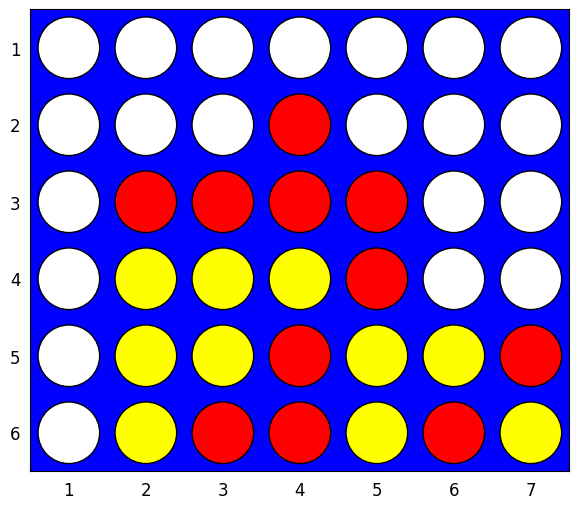

The winner is h-red


In [41]:
# # Without nonlosing logic!

# # Set up new game
# winner = 'nobody'
# board = np.zeros((6,7,2))
# plot_connect4(board)
# player = 'red'

# # Determine which color each player is (red goes first)
# human_player = input('Which player would you like to be? Red or yellow? Red goes first.').strip().lower()
# if human_player == 'red':
#   bot_player = 'yellow'
# else:
#   bot_player = 'red'

# # Determine which model to use
# selected_opponent = input('Please select your opponent: "CNN" or "Transformer"').strip().lower()
# if selected_opponent == 'cnn':
#     # Because I had an issue loading the model
#     custom_objects = {
#         'softmax_v2': tf.keras.activations.softmax
#     }
#     model = load_model('best_connect4_cnn.h5', custom_objects=custom_objects)
# else:
#     model = load_model('best_transformer.h5')


# while winner == 'nobody':
#     # Check for legal moves, else return 'tie'
#     legal = find_legal(board)
#     if len(legal) == 0:
#         winner = 'tie'
#         break
    
#     if player == human_player:
#         move = input('Pick a move (1-7) for player '+player+': ')
#         move = int(move) - 1 # convert player's move to index
#         board = update_board(board,human_player,move)
#         clear_output()
#         plot_connect4(board)
#         winner = check_for_win(board,move)
#     elif player != human_player:
#         print('Bot is thinking...')
        
#         # If bot is yellow, flip board for accurate predictions
#         if bot_player == 'yellow':
#             temp_board = np.flip(board, axis = 1) # don't want to actually save this board, just used for predictions
#             model_input = np.expand_dims(temp_board, axis=0) # need to include an extra dimension for sample size = 1
#             bot_moves = model.predict(model_input)[0] # just get the highest probability move
#             move = np.argmax(bot_moves)
#             board = update_board(board,bot_player,move)
#         else:
#             model_input = np.expand_dims(board, axis=0) # need to include an extra dimension for sample size = 1
#             bot_moves = model.predict(model_input)[0]
#             move = np.argmax(bot_moves) # just get the highest probability move
#             board = update_board(board,bot_player,move)

#         clear_output()
#         plot_connect4(board)

#     # Check for a win after either player plays
#     winner = check_for_win(board,move)
    
#     # Switch players and go onto the next turn if no one has won
#     if player == 'red':
#         player = 'yellow'
#     else:
#         player = 'red'

# print('The winner is '+winner)